In [1101]:
import torch
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
import smogn

In [1102]:
train_data = pd.read_csv('../data/train_data.csv')

In [1103]:
train_data

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [1104]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

# Display number of unique elements in each column

In [1105]:
for column in train_data.columns:
    print(f"Number of unique rows in {column}: {train_data[column].nunique()}")


Number of unique rows in SalePrice: 841
Number of unique rows in YearBuilt: 16
Number of unique rows in Size(sqf): 89
Number of unique rows in Floor: 43
Number of unique rows in HallwayType: 3
Number of unique rows in HeatingType: 2
Number of unique rows in AptManageType: 2
Number of unique rows in N_Parkinglot(Ground): 23
Number of unique rows in N_Parkinglot(Basement): 20
Number of unique rows in TimeToBusStop: 3
Number of unique rows in TimeToSubway: 5
Number of unique rows in N_manager: 9
Number of unique rows in N_elevators: 13
Number of unique rows in SubwayStation: 8
Number of unique rows in N_FacilitiesInApt: 9
Number of unique rows in N_FacilitiesNearBy(Total): 11
Number of unique rows in N_SchoolNearBy(Total): 14


In [1106]:
COLUMNS_TO_DUMMY = ["HeatingType","AptManageType", "HallwayType","TimeToBusStop","TimeToSubway","SubwayStation"]
OUTPUT_COLUMN = "SalePrice"

In [1107]:
def to_discrete(value):
    if value > CRITERIUM_MAX_AVERAGE:
        return 2
    elif value > CRITERIUM_MAX_CHEAP:
        return 1
    else:
        return 0

In [1108]:
discrete_column = train_data['SalePrice'].apply(to_discrete)
discrete_column.value_counts()

SalePrice
1    2992
2     570
0     562
Name: count, dtype: int64

In [1125]:
def classify(tensor) -> torch.tensor:
    return torch.where(tensor > CRITERIUM_MAX_AVERAGE, torch.tensor(2),
                       torch.where((tensor > CRITERIUM_MAX_CHEAP) & (tensor <= CRITERIUM_MAX_AVERAGE), torch.tensor(1),
                                   torch.tensor(0)))

In [1126]:
def count_unique_elements(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    for unique, count in zip(unique_elements, counts):
        print(f"Class {unique.item()}: {count.item()} occurrences")

In [1167]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler = None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.label = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
        self.data = torch.tensor(self.data.iloc[:,1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]
    
    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns
    
    def get_non_dummy_columns(self) -> List[str]:
        return [column for column in self.data.columns if column not in COLUMS_TO_DUMMY]
    
    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(self.data[column].values.reshape(-1, 1))
        
    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMS_TO_DUMMY)
        self.conduct_smogn()
        # self._duplicate_rows()
        self.shuffle()
        if self.scaler:
            self._scale_data()
    
    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        return data, labels
    
    def conduct_smogn(self) -> None:
        rg_mtrx = [
            [CRITERIUM_MAX_CHEAP, 1, 0],  # oversample class 0
            [CRITERIUM_MAX_AVERAGE, 0, 0],  # undersample class 1
            [3000000, 0, 0],  # undersample class 2
        ]
        self.data = smogn.smoter(data=self.data, y=OUTPUT_COLUMN, rel_thres=0.35, samp_method='extreme', k = 6, rel_method='manual', rel_ctrl_pts_rg=rg_mtrx)
    
    def _duplicate_rows(self, number_of_duplicates: int = 2) -> None:
        rows_to_duplicate = self.data[(self.data.iloc[:,0] < CRITERIUM_MAX_CHEAP) | (self.data.iloc[:,0] > CRITERIUM_MAX_AVERAGE)]
        self.data = pd.concat([self.data, rows_to_duplicate.loc[rows_to_duplicate.index.repeat(number_of_duplicates)]], ignore_index=True)
    
    def shuffle(self):
        self.data.sample(frac = 1)
        
        

In [1168]:
path = '../data/train_data.csv'
scaler = MinMaxScaler()
train_dataset = HouseDataset(path, scaler)

r_index: 100%|##########| 1085/1085 [00:00<00:00, 1388.20it/s]


In [1169]:
train_data, train_labels = train_dataset.get_data_as_pandas()

In [1170]:
train_labels.iloc[:,0].apply(to_discrete).value_counts()

0
1    1967
2    1470
0     229
Name: count, dtype: int64

In [1115]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.783784,0.544505,0.565287,0.009818,0.457986,0.307692,0.185185,0.444444,0.562500,0.294118,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.729730,0.353769,0.420219,0.093969,0.604088,0.384615,0.000000,0.666667,0.812500,0.882353,...,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.783784,0.332879,0.213238,0.000000,0.961393,1.000000,0.592593,1.000000,0.562500,0.588235,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
3,0.972973,0.229923,0.418644,0.126227,0.888721,0.461538,0.740741,0.888889,0.875000,1.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
4,0.912328,0.474492,0.251534,0.334835,0.730991,0.412222,0.622017,0.710803,0.774827,0.830295,...,0.0,0.0,0.0,0.320554,0.0,0.0,0.0,0.679446,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,0.783784,0.814260,0.547619,0.000000,0.961393,1.000000,0.592593,1.000000,0.562500,0.588235,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
2847,1.000000,0.231154,0.500000,0.143058,0.302801,0.307692,0.370370,0.666667,0.437500,0.647059,...,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0
2848,0.783784,0.332879,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.562500,0.588235,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
2849,0.000000,0.541326,0.000000,0.122020,0.000000,0.000000,0.148148,0.222222,0.437500,0.647059,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0


In [1136]:
labels = classify(train_dataset.label)
count_unique_elements(labels)

Class 0: 277 occurrences
Class 1: 1482 occurrences
Class 2: 2342 occurrences


In [1117]:
# path = '../data/train_data.csv'
# scaler = MinMaxScaler()
# train_dataset = HouseDataset(path, scaler)

r_index: 100%|##########| 789/789 [00:00<00:00, 1312.71it/s]


# Split the data into training and validation sets

In [1084]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset.data, train_dataset.label, test_size=0.2, random_state=42)
train_data = data.TensorDataset(X_train, y_train)
validation_data = data.TensorDataset(X_test, y_test)

# Create the data loaders

In [1085]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [1086]:
class HousingRegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [1087]:
model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)

In [1088]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=0.001)

In [1089]:
loss_fn = nn.MSELoss()

In [1090]:
mca = MulticlassAccuracy(num_classes=3, average=None)

In [1091]:
EPOCHS_NUMBER = 1000
train_losses,train_accuracies, val_losses, val_accuracies  = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model.train()
    batch_idx = 0
    for data, label in train_loader:
        optimizer.zero_grad()
        model_output = model(data).squeeze()
        loss = loss_fn(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        batch_idx += 1
        train_predicts_classify = classify(model_output)
        train_data_classify = classify(label)
        train_batch_accuracy_sum += mca(train_predicts_classify, train_data_classify)
    train_batch_accuracy_avg = train_batch_accuracy_sum/batch_idx
    mean_error_train = train_batch_loss_sum/len(train_loader)
    train_losses.append(mean_error)
    train_accuracies.append(train_batch_accuracy_avg)
    model.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader:
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = loss_fn(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (len(train_loader.dataset))
        val_batch_loss = val_batch_loss_sum / (len(validation_loader.dataset))
        train_losses.append(train_batch_loss)
        val_losses.append(val_batch_loss)
        batch_val_idx += 1
        val_predicts_classify = classify(val_predicts)
        val_data_classify = classify(val_labels)
        val_batch_accuracy_sum += mca(val_predicts_classify, val_data_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum/batch_val_idx
    mean_error_val = val_batch_loss_sum/len(train_loader)
    tqdm_progress.set_postfix({"Epoch": epoch+1, "Loss in train": {mean_error_train}, "Loss in eval": {mean_error_val}})
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s, Epoch=1000, Loss in train={9353680051.649122}, Loss in eval={8378066712.701755}]


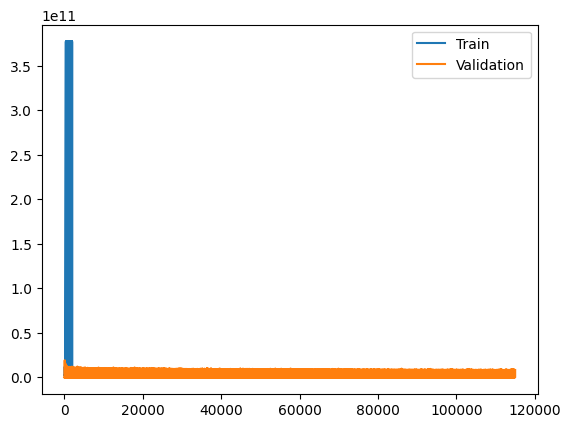

In [1092]:
plt.plot(loss_train,label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()

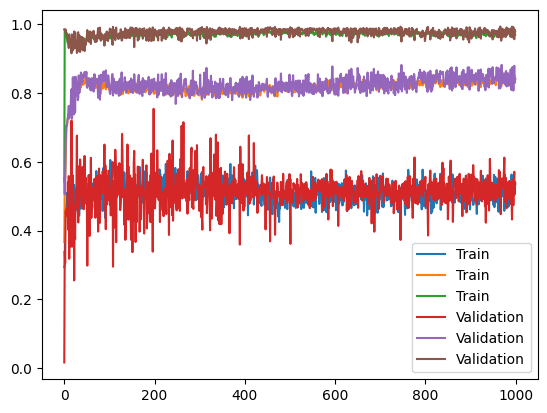

In [1093]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [1094]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

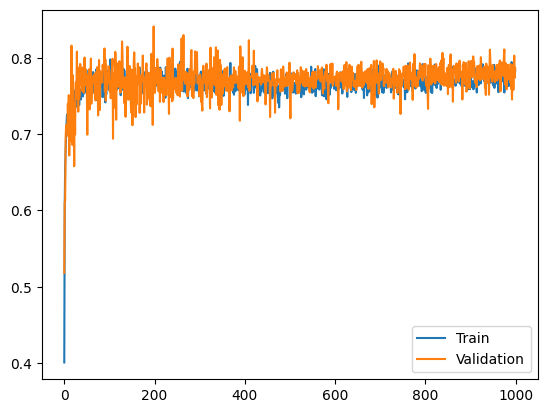

In [1095]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()

In [1096]:
val_accuracies_mean

[0.5182428359985352,
 0.6107907295227051,
 0.612801730632782,
 0.6944832801818848,
 0.7105772495269775,
 0.7119953632354736,
 0.7084479331970215,
 0.7082296013832092,
 0.7397503852844238,
 0.6972052454948425,
 0.7510344982147217,
 0.6718661785125732,
 0.714148759841919,
 0.6916710734367371,
 0.7254950404167175,
 0.6979112029075623,
 0.8158845901489258,
 0.7341827750205994,
 0.6858265995979309,
 0.7771777510643005,
 0.6926278471946716,
 0.7328715324401855,
 0.657858669757843,
 0.7401332855224609,
 0.6993444561958313,
 0.7668800354003906,
 0.7681021094322205,
 0.7602665424346924,
 0.8079695105552673,
 0.7459868788719177,
 0.7549346089363098,
 0.7293068766593933,
 0.7869489789009094,
 0.7460291981697083,
 0.7529019713401794,
 0.7918915152549744,
 0.7902683615684509,
 0.7689349055290222,
 0.764738142490387,
 0.7738481163978577,
 0.7564776539802551,
 0.7870547771453857,
 0.760246992111206,
 0.7543780207633972,
 0.7851681709289551,
 0.8003268837928772,
 0.773852527141571,
 0.7854000926017761

In [1097]:
torch.save(model.state_dict(), "../models/housing_model.pth")